In [8]:
from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from dmba import plotDecisionTree, classificationSummary, regressionSummary

%matplotlib inline

# Load the data and preprocess the data. 

In [9]:
#Load the Universal Bank Data

universal_bank_df = pd.read_csv("UniversalBank.csv")

# Change the column Names
universal_bank_df.columns = [col.replace(' ', '_') for col in universal_bank_df.columns]
col_list = ['Education', 'Personal_Loan', 'Securities_Account','CD_Account', 'Online', 'CreditCard']

for col in col_list:
    print(col, "unique values",universal_bank_df[col].unique())

universal_bank_df[col_list] = universal_bank_df[col_list].astype('category')
universal_bank_df.head()
universal_bank_df.shape

Education unique values [1 2 3]
Personal_Loan unique values [0 1]
Securities_Account unique values [1 0]
CD_Account unique values [0 1]
Online unique values [0 1]
CreditCard unique values [0 1]


(5000, 14)

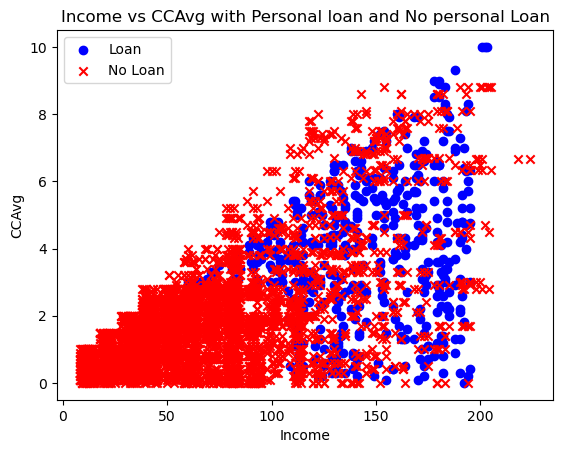

In [10]:
# Draw a scatter plot to check for any observation if it may. I did ran the observations
# for the multiple combinations of personal loan vs experience, zip and such and the one below seemed real 
#interesting such that if you have income and any CC score average. It yielded some pattern.

loan_df = universal_bank_df[universal_bank_df['Personal_Loan'] == 1]
non_loan_df = universal_bank_df.drop(loan_df.index)
#print(loan_df.head())
#print(non_loan_df.head())

plt.scatter(loan_df['Income'], loan_df['CCAvg'], label='Loan', color='blue')
plt.scatter(non_loan_df['Income'], non_loan_df['CCAvg'], label='No Loan', color='red', marker='x')
# Add labels and legend
plt.xlabel("Income")
plt.ylabel("CCAvg")
plt.legend()
plt.title("Income vs CCAvg with Personal loan and No personal Loan")
plt.show()

# Observation 

As the income is lower we hardly see any personal loans were disbursed however as the income grows CC avg also comes into the picture and shows us the pattern  than both are somewhat relevant mostly between 90K-140K approx and then CC avg seems to have less impact on personal loan account as the income is on higher spectrum.
This is just an observation and may not be concluded as a causation nor correlation. It just a interesting trend of observation on the sample data being provided.


In [11]:
# we gonna drop the ID column/attribute as ID has no context in terms of data analysis and may make 
# the model more prune to noise.
X = universal_bank_df.drop(['ID', 'Personal_Loan'], axis=1)
y = universal_bank_df['Personal_Loan']
X.head()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Personal_Loan, dtype: category
Categories (2, int64): [0, 1]

In [12]:
bank_df = universal_bank_df
newBankData = pd.DataFrame([{'Age':50, 'Experience':30, 'Income':58, 'ZIP_Code':900034, 'Family':3, 'CCAvg':0.8, 'Education':3, 'Mortgage':0, 'Personal_Loan':0, 'Securities_Account':0, 'CD_Account':0, 'Online':1, 'CreditCard':1}])
newBankData

,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,50,30,58,900034,3,0.8,3,0,0,0,0,1,1


In [13]:
#Partition the data into train and valid. Make sure you set seed
trainData = bank_df.sample(frac=0.6, random_state=1)
# sample 40% of the row IDs into the validation set, 
validData = bank_df.drop(trainData.index) 
trainData.shape

(3000, 14)

In [17]:

scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Age', 'Experience', 'Income', 'ZIP_Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']])  

# Transform the full dataset
bankNorm = pd.concat([pd.DataFrame(scaler.transform(bank_df[['Age', 'Experience', 'Income', 'ZIP_Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']]), 
                                    columns=['zAge', 'zExperience', 'zIncome', 'zZIP_Code', 'zFamily', 'zCCAvg', 'zEducation', 'zMortgage', 'zPersonal_Loan', 'zSecurities_Account', 'zCD_Account', 'zOnline', 'zCreditCard']),
                       bank_df[['Personal_Loan']]], axis=1)
trainNorm = bankNorm.iloc[trainData.index]
validNorm = bankNorm.iloc[validData.index]

#Scale the new data
newBankNorm = pd.DataFrame(scaler.transform(newBankData[['Age', 'Experience', 'Income', 'ZIP_Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']]), 
                                    columns=['zAge', 'zExperience', 'zIncome', 'zZIP_Code', 'zFamily', 'zCCAvg', 'zEducation', 'zMortgage', 'zPersonal_Loan', 'zSecurities_Account', 'zCD_Account', 'zOnline', 'zCreditCard'])
#newBankNorm
newBankNorm

,zAge,zExperience,zIncome,zZIP_Code,zFamily,zCCAvg,zEducation,zMortgage,zPersonal_Loan,zSecurities_Account,zCD_Account,zOnline,zCreditCard
0,0.430565,0.883387,-0.34395,458.271391,0.533557,-0.653554,1.349068,-0.550135,-0.322107,-0.336411,-0.249646,0.810838,1.529953


In [15]:
knn = KNeighborsClassifier(n_neighbors=3).fit(trainNorm[['zAge', 'zExperience', 'zIncome', 'zZIP_Code', 'zFamily', 'zCCAvg', 'zEducation', 'zMortgage', 'zPersonal_Loan', 'zSecurities_Account', 'zCD_Account', 'zOnline', 'zCreditCard']], 
                                              trainNorm['Personal_Loan'])
distances, indices = knn.kneighbors(newBankNorm)
print('personal loan')
print(knn.predict(newBankNorm))
print('\n')
print('Distances')
print('Distances',distances)
print('\n')
print('Indicies')
print('Indices', indices)
print('\n')
print('All cols')
print(trainNorm.iloc[indices[0], :])

personal loan
[0]


Distances
Distances [[456.29723472 456.30167971 456.30560293]]


Indicies
Indices [[ 398 1309 2478]]


All cols
          zAge  zExperience   zIncome  zZIP_Code   zFamily    zCCAvg  \
1426 -0.699298    -0.766397 -0.299957   1.983796  0.533557 -0.824714   
3525  1.212778     1.230710 -1.333809   1.983796  1.409677 -0.596501   
2731 -1.394599    -1.287381 -1.003856   1.983796 -1.218683 -0.995874   

      zEducation  zMortgage  zPersonal_Loan  zSecurities_Account  zCD_Account  \
1426    1.349068  -0.550135       -0.322107            -0.336411    -0.249646   
3525    0.155555  -0.550135       -0.322107            -0.336411    -0.249646   
2731    1.349068  -0.550135       -0.322107            -0.336411    -0.249646   

       zOnline  zCreditCard Personal_Loan  
1426  0.810838    -0.653615             0  
3525 -1.233292    -0.653615             0  
2731  0.810838    -0.653615             0  


In [64]:
#Try using knn for valid dataset
knn.kneighbors(validNorm[['zAge', 'zExperience', 'zIncome', 'zZIP_Code', 'zFamily', 'zCCAvg', 'zEducation', 'zMortgage', 'zPersonal_Loan', 'zSecurities_Account', 'zCD_Account', 'zOnline', 'zCreditCard']])
knn.predict(validNorm[['zAge', 'zExperience', 'zIncome', 'zZIP_Code', 'zFamily', 'zCCAvg', 'zEducation', 'zMortgage', 'zPersonal_Loan', 'zSecurities_Account', 'zCD_Account', 'zOnline', 'zCreditCard']])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [65]:


# Scale the features using MinMaxScaler
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_valid_scaled = scaler.transform(X_valid)

In [66]:
#knn_model = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors
#knn_model.fit(X_train_scaled, y_train)

In [67]:
# Make predictions on the test set
#y_pred = knn_model.predict(X_valid_scaled)
#print(y_pred)
#pd.concat([X_valid,y_valid],axis =1)

We have trained on 75% of the data and noticed the above data was used as the new data/input data for which it needs to predict the values for. We choose to use the values from overall data itself instead of cooking something by ourselves. 

# Below is the acurracy metrics for knn3

In [83]:
# Evaluate the model for Knn as 3
y_pred = knn_model.predict(valid_X)
# We tested on the valid data and trained the data on 90% of the data.
accuracy = accuracy_score(valid_y, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9006666666666666


C:\Users\kylem\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


# Identify which kNN level is best 

     k  accuracy
0    1    0.9480
1    2    0.9445
2    3    0.9540
3    4    0.9440
4    5    0.9545
5    6    0.9460
6    7    0.9490
7    8    0.9460
8    9    0.9495
9   10    0.9450
10  11    0.9475
11  12    0.9415
12  13    0.9455
13  14    0.9410


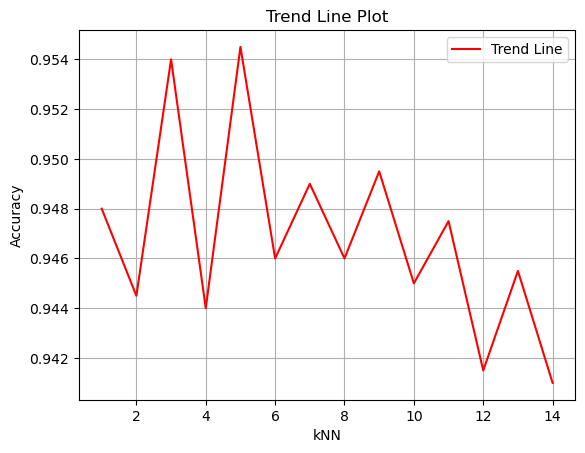

In [69]:
train_X = trainNorm[['zID', 'zAge', 'zExperience', 'zIncome', 'zZIP_Code', 'zFamily', 'zCCAvg', 'zEducation', 'zMortgage', 'zSecurities_Account', 'zCD_Account', 'zOnline', 'zCreditCard']]
train_y = trainNorm['Personal_Loan']
valid_X = validNorm[['zID', 'zAge', 'zExperience', 'zIncome', 'zZIP_Code', 'zFamily', 'zCCAvg', 'zEducation', 'zMortgage', 'zSecurities_Account', 'zCD_Account', 'zOnline', 'zCreditCard']]
valid_y = validNorm['Personal_Loan']

# Train a classifier for different values of k
#X_train, X_valid, y_train, y_valid,X_train_scaled,X_valid_scaled
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)
plt.plot(results['k'], results['accuracy'], color='red', label='Trend Line')
plt.title('Trend Line Plot')
plt.xlabel('kNN')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In order to do that we can run the knn for 20 nearest neighbors, even though seems like 50 would be too much. 
However, as per the observation it looks like as the nearest neighbors size increases the prediction quality decreases. Which makes sense as we are trying to average out based on the higher number of  neighbors and then finding the nearest ones.

The plot diagram also suggests that the accuracy kind of flattens around with knn of 17 to 32. 
So, we can suggest to have a kNN level of around 17-18 to have more consistent results and avoid any overfitting as such.

Though this is a crude approach a more systematic and finner approach should help further.

# Now consider solving for Classification Trees
We will consider the raw data and avoid the columns such as ID. 

In [70]:

#Drop ID and Zipcode columns
cft_universal_bank = universal_bank_df.drop(['ID'], axis=1)
cft_universal_bank.columns

predictors =['Age', 'ZIP_Code','Experience', 'Income', 'Family', 'CCAvg', 'Education','Mortgage',
             'Securities_Account', 'CD_Account','Online', 'CreditCard']
outcome = 'Personal_Loan'


#Partition
X = cft_universal_bank[predictors]
y = cft_universal_bank[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)
print(valid_y.head())

#Develop trees
classTreeBank = DecisionTreeClassifier(random_state=0, max_depth=4)
classTreeBank.fit(train_X, train_y) #First one is X (predictors) and the second one is Y (target)
classificationSummary(train_y, classTreeBank.predict(train_X))


2764    0
4767    0
3814    0
3499    0
2735    0
Name: Personal_Loan, dtype: category
Categories (2, int64): [0, 1]
Confusion Matrix (Accuracy 0.9886)

       Prediction
Actual    0    1
     0 3158   11
     1   29  302


In [71]:
classificationSummary(valid_y, classTreeBank.predict(valid_X))


Confusion Matrix (Accuracy 0.9813)

       Prediction
Actual    0    1
     0 1343    8
     1   20  129


Classes: 0, 1


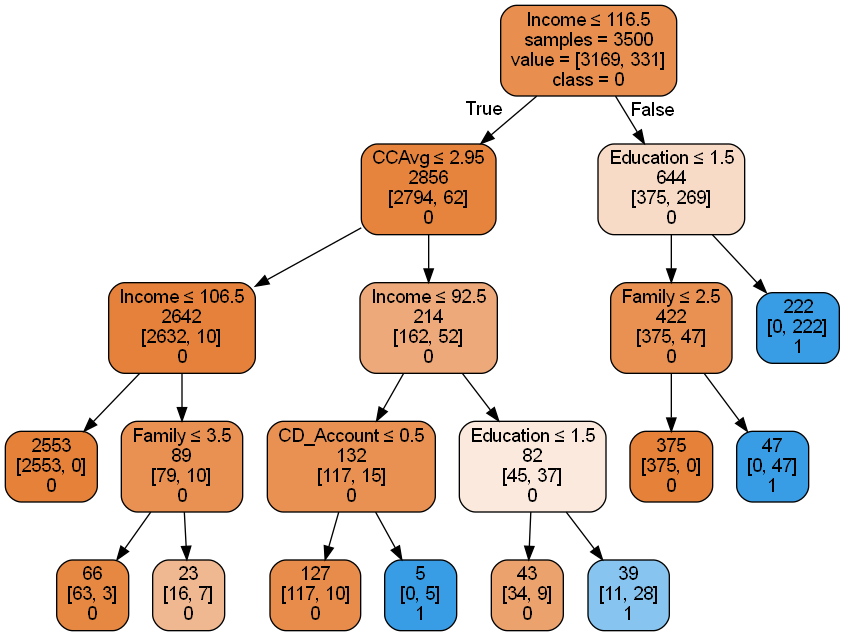

In [72]:

class_labels_str = list(map(str, classTreeBank.classes_))
print("Classes: {}".format(', '.join(class_labels_str)))
plotDecisionTree(classTreeBank, feature_names=X.columns[:12], class_names=classTreeBank.classes_)

# Ebay Auctions Data Analysis

Interest of variable is competitive auction. duration, opening price, currency and endDay are the variables choosen by seller.



In [73]:
ebay_auc_df = pd.read_csv("eBayAuctions.csv")
ebay_auc_df.rename(columns={'Competitive?':'Competitive'}, inplace=True) 
ebay_auc_df.head()


,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [74]:
# Assuming df is your DataFrame with the provided data
# If 'Category', 'currency', and 'endDay' are not numerical, we'll encode them using LabelEncoder
label_encoder_category = LabelEncoder()
label_encoder_currency = LabelEncoder()
label_encoder_endDay = LabelEncoder()

ebay_auc_df['enc_Category'] = label_encoder_category.fit_transform(ebay_auc_df['Category'])
ebay_auc_df['enc_currency'] = label_encoder_currency.fit_transform(ebay_auc_df['currency'])
ebay_auc_df['enc_endDay'] = label_encoder_endDay.fit_transform(ebay_auc_df['endDay'])



In [75]:
x_col_list = ['enc_Category', 'enc_currency', 'sellerRating', 'Duration', 'enc_endDay',
            'ClosePrice', 'OpenPrice']
#x_col_list = ['sellerRating', 'Duration','ClosePrice', 'OpenPrice']
y_col_list = 'Competitive'

x_data = ebay_auc_df[x_col_list]
y_data = ebay_auc_df[y_col_list]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x_data)

X_train_ebay, X_valid_ebay, y_train_ebay, y_valid_ebay = train_test_split(x_data, y_data, test_size=0.5, random_state=42)
#Develop trees
classTree_ebay = DecisionTreeClassifier(min_samples_leaf=50,min_samples_split=50,random_state=0, max_depth=7)
classTree_ebay.fit(X_train_ebay, y_train_ebay) #First one is X (predictors) and the second one is Y (target)
classificationSummary(y_train_ebay, classTree_ebay.predict(X_train_ebay))

Confusion Matrix (Accuracy 0.8377)

       Prediction
Actual   0   1
     0 405  58
     1 102 421


In [76]:
classificationSummary(y_valid_ebay, classTree_ebay.predict(X_valid_ebay))

Confusion Matrix (Accuracy 0.8114)

       Prediction
Actual   0   1
     0 386  57
     1 129 414


Classes: 0, 1


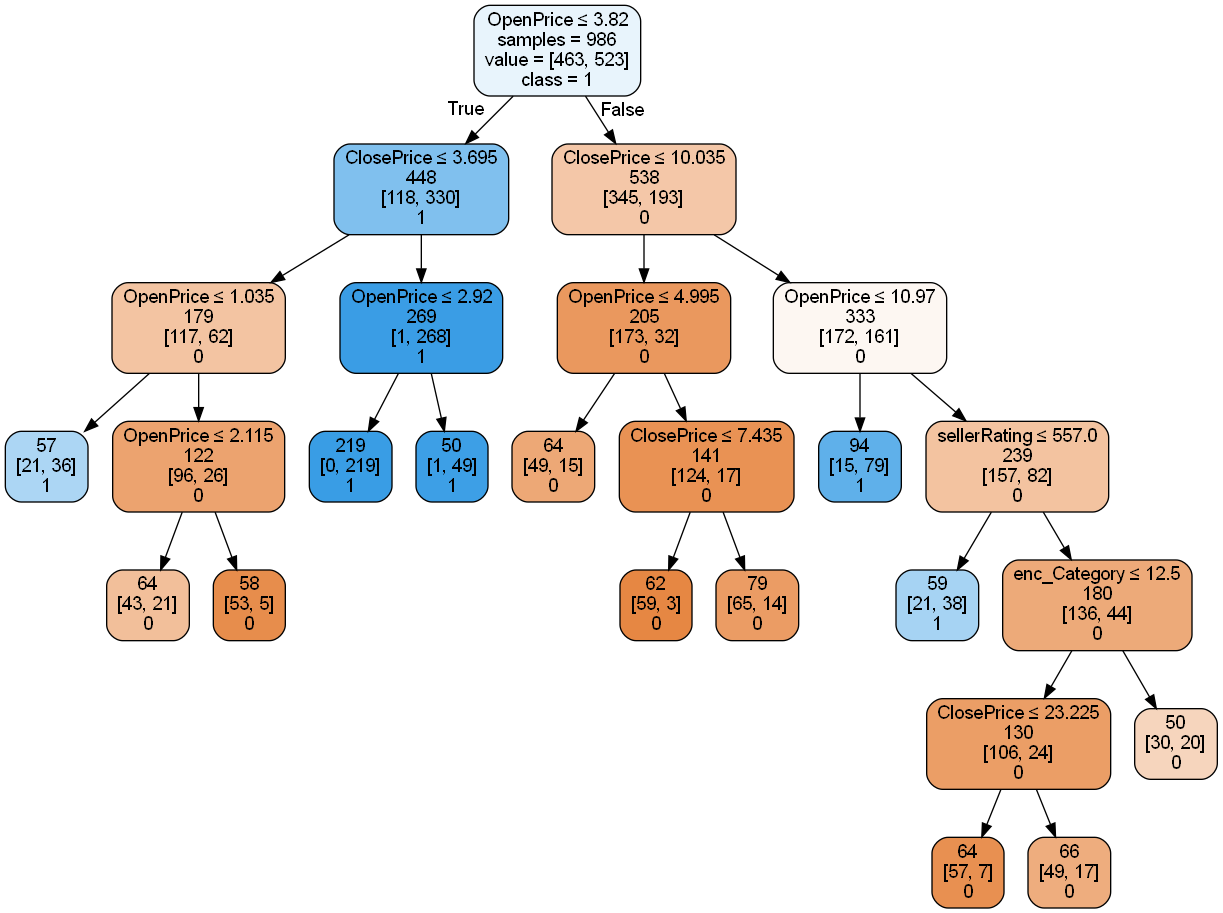

In [77]:
class_labels_str = list(map(str, classTree_ebay.classes_))
print("Classes: {}".format(', '.join(class_labels_str)))
plotDecisionTree(classTree_ebay, feature_names=X_train_ebay.columns[:7], class_names=classTree_ebay.classes_)

a. As you can see the above tree has minimum 50 items on the terminal nodes and the tree depth is 7.

One rule we can build is for is -  if the open price is 2 and closing price is 12 in this we have the the first node condition openPrice <=3.82 so we go to the true node and we see teh closePrice condition as <=3.685 so we go to the right as false and again our open price is 2 which is True for node hence we go to the right edge and notice that its 1. Hence for Open Price as 2 and Closing price as 12 we get the Competitive as 1. 

This tree does not seem to work in our case as in real life you would not know the closed price, you would not as a seller before hand, so we should remove this from the training data. Also currency is irrelevant as its same value and does not actually helps in this scenario. 

# Let's build model with new variables.

In [78]:
new_x_col_list = ['enc_Category','sellerRating', 'Duration', 'enc_endDay', 'OpenPrice']
#x_col_list = ['sellerRating', 'Duration','ClosePrice', 'OpenPrice']
new_y_col_list = 'Competitive'

new_x_data = ebay_auc_df[new_x_col_list]
new_y_data = ebay_auc_df[new_y_col_list]

new_scaler = MinMaxScaler()
new_X_scaled = new_scaler.fit_transform(new_x_data)

new_X_train_ebay, new_X_valid_ebay, new_y_train_ebay, new_y_valid_ebay = train_test_split(new_x_data, new_y_data, test_size=0.5, random_state=42)
#Develop trees
new_classTree_ebay = DecisionTreeClassifier(min_samples_leaf=50,min_samples_split=50,random_state=0, max_depth=7)
new_classTree_ebay.fit(new_X_train_ebay, new_y_train_ebay) #First one is X (predictors) and the second one is Y (target)
classificationSummary(new_y_train_ebay, new_classTree_ebay.predict(new_X_train_ebay))

Confusion Matrix (Accuracy 0.7343)

       Prediction
Actual   0   1
     0 349 114
     1 148 375


In [79]:
classificationSummary(new_y_valid_ebay, new_classTree_ebay.predict(new_X_valid_ebay))

Confusion Matrix (Accuracy 0.7110)

       Prediction
Actual   0   1
     0 321 122
     1 163 380


Classes: 0, 1


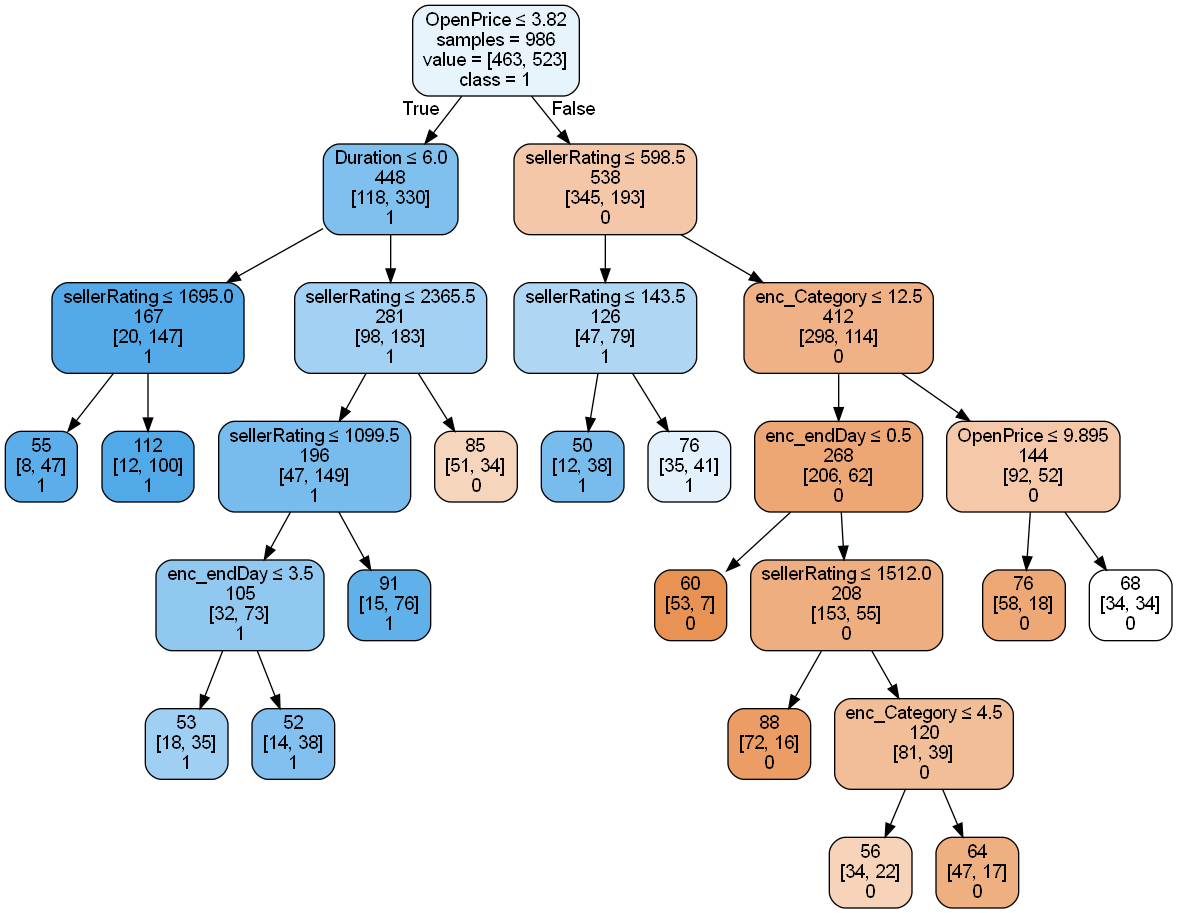

In [80]:
new_class_labels_str = list(map(str, new_classTree_ebay.classes_))
print("Classes: {}".format(', '.join(new_class_labels_str)))
plotDecisionTree(new_classTree_ebay, feature_names=new_X_train_ebay.columns[:5], class_names=new_classTree_ebay.classes_)

In [81]:
print(ebay_auc_df.drop_duplicates(subset=['enc_Category','Category'])[['enc_Category','Category']].sort_values(by = 'enc_Category'))
print(ebay_auc_df.drop_duplicates(subset=['enc_endDay','endDay'])[['enc_endDay','endDay']].sort_values(by = 'enc_endDay'))

     enc_Category              Category
195             0     Antique/Art/Craft
16              1            Automotive
133             2                 Books
143             3   Business/Industrial
187             4  Clothing/Accessories
188             5          Coins/Stamps
140             6          Collectibles
164             7              Computer
160             8           Electronics
175             9        EverythingElse
347            10         Health/Beauty
106            11           Home/Garden
208            12               Jewelry
0              13      Music/Movie/Game
728            14           Photography
217            15         Pottery/Glass
25             16         SportingGoods
148            17          Toys/Hobbies
     enc_endDay endDay
25            0    Fri
0             1    Mon
133           2    Sat
143           3    Sun
106           4    Thu
16            5    Tue
213           6    Wed


Recommendation -

The new model captures more rules and have more structured approach in terms of determining if the acution was competitive or not. 
The enc_endDay, ENC EndDay, Enc Category  are the encoded values for as they cannot be put into the decision tree algorithm for classification hence we labeled them and then did the scaller fit. 

At 50% split we have an accuracy of 73% on training data nnd 71% on validation which is around similar and hence it could be a better decision tree then having a variable part of the decision tree for which we do not know the value yet.
